<a href="https://colab.research.google.com/github/btdat2506/DeepOOC_PyTorch/blob/main/DeepOOC_Adversarial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import logging
import time
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda
from torch.nn.functional import normalize

import matplotlib.pyplot as plt

In [2]:
# Set hardware

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
def GlobalContrastNormalization(tensor: torch.tensor, scale='l2'):
    assert scale in ('l1', 'l2')
    n_features = int(np.prod(tensor.shape))

    tensor = tensor - torch.mean(tensor)

    if (scale == 'l1'):
        tensor = tensor / torch.mean(torch.abs(tensor))

    if (scale == 'l2'):
        tensor = tensor / torch.sqrt(torch.sum(tensor ** 2) / n_features)

    return tensor

In [4]:
def get_target_label_idx(labels, targets):
    """
    Get the indices of labels that are included in targets.
    :param labels: array of labels
    :param targets: list/tuple of target labels
    :return: list with indices of target labels
    """
    return [idx for idx, label in enumerate(labels) if label in targets]

In [5]:
normal_class = 0

n_classes = 2
normal_classes = tuple([normal_class])
# outlier_classes = list(range(0, 10))
# outlier_classes.remove(normal_class)

outlier_classes = 1

min_max = [(-0.8826567065619495, 9.001545489292527),
           (-0.6661464580883915, 20.108062262467364),
           (-0.7820454743183202, 11.665100841080346),
           (-0.7645772083211267, 12.895051191467457),
           (-0.7253923114302238, 12.683235701611533),
           (-0.7698501867861425, 13.103278415430502),
           (-0.778418217980696, 10.457837397569108),
           (-0.7129780970522351, 12.057777597673047),
           (-0.8280402650205075, 10.581538445782988),
           (-0.7369959242164307, 10.697039838804978)]

transform = Compose([ToTensor(),
                     Lambda(lambda x: GlobalContrastNormalization(x, scale='l1')),
                     Normalize([min_max[normal_class][0]],
                               [min_max[normal_class][1] - min_max[normal_class][0]])])
target_transform = Lambda(lambda x: outlier_classes)

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
    target_transform=target_transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
    target_transform=target_transform,
)

train_idx_normal = get_target_label_idx(training_data.train_labels.clone().data.cpu().numpy(), normal_classes)
train_data = Subset(training_data, train_idx_normal)

test_classes = tuple([0, 1])
test_idx = get_target_label_idx(test_data.test_labels.clone().data.cpu().numpy(), test_classes)
test_data = Subset(test_data, test_idx)

100%|██████████| 9912422/9912422 [00:00<00:00, 258240647.25it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 47042987.89it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 101450658.60it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2606804.70it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
class MNIST_LeNet_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.rep_dim = 32
        self.pool = nn.MaxPool2d(2, 2)

        # Encoder: Same as Deep Out-of-Context (OOC) network
        self.conv1 = nn.Conv2d(1, 8, 5, bias=False, padding=2)
        self.bn1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(8, 4, 5, bias=False, padding=2)
        self.bn2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(4 * 7 * 7, self.rep_dim, bias=False)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(2, 4, 5, bias=False, padding=2)
        self.bn3 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.deconv2 = nn.ConvTranspose2d(4, 8, 5, bias=False, padding=3)
        self.bn4 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 5, bias=False, padding=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(nn.functional.leaky_relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(nn.functional.leaky_relu(self.bn2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = x.view(x.size(0), int(self.rep_dim / 16), 4, 4)
        x = nn.functional.interpolate(nn.functional.leaky_relu(x), scale_factor=2)
        x = self.deconv1(x)
        x = nn.functional.interpolate(nn.functional.leaky_relu(self.bn3(x)), scale_factor=2)
        x = self.deconv2(x)
        x = nn.functional.interpolate(nn.functional.leaky_relu(self.bn4(x)), scale_factor=2)
        x = self.deconv3(x)
        x = torch.sigmoid(x)

        return x

In [7]:
class MNIST_LeNet_Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.rep_dim = 32
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(1, 8, 5, bias=False, padding=2)
        self.bn1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(8, 4, 5, bias=False, padding=2)
        self.bn2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(4 * 7 * 7, self.rep_dim, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(nn.functional.leaky_relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(nn.functional.leaky_relu(self.bn2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [8]:
# Configuration for Pretrain and Train
optimizer_name: str = 'adam'
lr: float = 0.001
n_epochs: int = 150
lr_milestones: tuple = ()
batch_size: int = 128
weight_decay: float = 1e-6
n_jobs_dataloader: int = 0

ae_net = MNIST_LeNet_AutoEncoder().to(device)
net = MNIST_LeNet_Network().to(device)

In [9]:
model_dict = torch.load('saved_model/model.tar')

R = model_dict['R']
c = model_dict['c']
net.load_state_dict(model_dict['net_dict'])
ae_net.load_state_dict(model_dict['ae_net_dict'])

<All keys matched successfully>

In [10]:
R = torch.tensor(R, device=device)
c = torch.tensor(c, device=device)

In [11]:
train_loader = DataLoader(train_data, batch_size, num_workers=n_jobs_dataloader)
test_loader = DataLoader(test_data, batch_size, num_workers=n_jobs_dataloader)


In [12]:
def normalize_0_to_1_dist(dist):
    # Normalize distances to range [0, 1]
    dist_min = torch.min(dist)
    dist_max = torch.max(dist)
    return (dist - dist_min) / (dist_max - dist_min)

In [20]:
def get_border_indices(yp, c, R, low_threshold, high_threshold):
    # Calculate distances
    dist = torch.sum((yp - c) ** 2, dim=1).sqrt()

    # Get the indices that would sort the distances
    sorted_indices = torch.argsort(dist)

    # Use these sorted indices to rearrange X, y, yp, and the normalized distances
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]
    yp_sorted = yp[sorted_indices]
    dist_sorted = dist[sorted_indices]

    # Select only the indices where dist_sorted is between low_threshold and high_threshold
    selected_indices = (dist_sorted >= low_threshold) & (dist_sorted <= high_threshold)

    return [selected_indices, X_sorted[selected_indices], yp_sorted[selected_indices], dist_sorted[selected_indices]]

In [18]:
def modified_plot_border_images(X, yp, dist, M, N, low_threshold, high_threshold):
    # Calculate the number of images to plot, adjusted for the number of selected images
    num_selected_images = X.shape[0]
    M = num_selected_images // N + (num_selected_images % N != 0)  # Ensure all images can be plotted

    # Initialize the plot
    f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N, M*1.3))

    # Iterate over the selected images and plot
    for i in range(num_selected_images):
        ax_pos = (i // N, i % N)
        ax[ax_pos].imshow(1 - X[i][0].cpu().detach().numpy(), cmap="gray")
        title_text = "Dist: {:.2f}".format(dist[i].item())
        title = ax[ax_pos].set_title(title_text)
        plt.setp(title) # color=('g' yp[i] < (high_threshold + low_threshold) / 2 else 'r')
        ax[ax_pos].set_axis_off()

    # Turn off any unused subplots
    for i in range(num_selected_images, M * N):
        ax[i // N][i % N].axis('off')

    plt.tight_layout()
    plt.show()

Streaming output truncated to the last 5000 lines.
  visible: bool
  wrap: bool
  x: float
  y: float
  zorder: float
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'exp

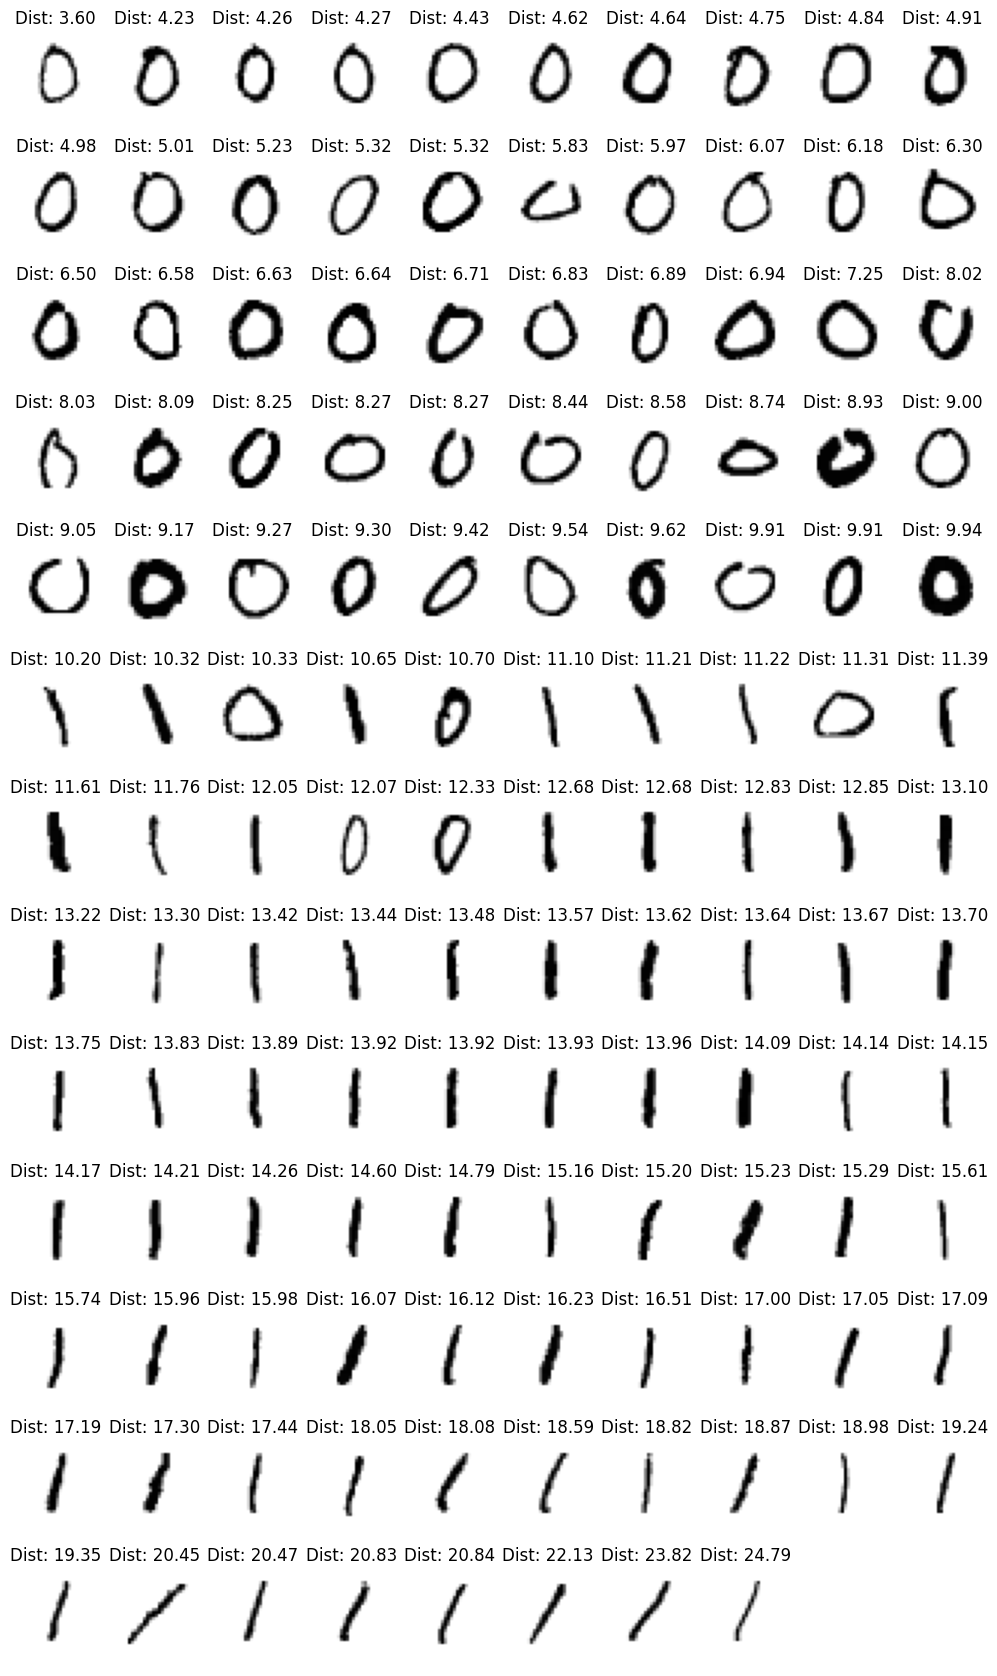

In [22]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

yp = net(X)

[selected_indicies, X, yp, dist] = get_border_indices(yp, c, R, 0, 500)
modified_plot_border_images(X, yp, dist, 10, 10, 0, 500)
